In [ ]:
import pandas as pd

df = pd.read_csv('../data/Marion.lnk/MG_D.csv')

print(df.head())

   2024-04-15 08:00:05.130  -0.031250  0.250000  1.078125
0  2024-04-15 08:00:05.140  -0.578125  0.093750  0.734375
1  2024-04-15 08:00:05.150  -0.593750  0.093750  0.781250
2  2024-04-15 08:00:05.159  -0.593750  0.093750  0.781250
3  2024-04-15 08:00:05.170  -0.593750  0.109375  0.781250
4  2024-04-15 08:00:05.180  -0.593750  0.093750  0.781250


In [3]:
noms_colonnes = df.columns
print(f"Les noms des colonnes dans le tableau sont : {noms_colonnes}") 
df.columns = ['date_heure', 'X', 'Y', 'Z']
print(f"Nouveaux noms des colonnes : {df.columns}")

Les noms des colonnes dans le tableau sont : Index(['2024-04-15 08:00:05.130', '-0.031250', '0.250000', '1.078125'], dtype='object')
Nouveaux noms des colonnes : Index(['date_heure', 'X', 'Y', 'Z'], dtype='object')


In [5]:
# Convert 'date_heure' to datetime
df['date_heure'] = pd.to_datetime(df['date_heure'])

# Resample df to 10Hz 
df_resampled = df.set_index('date_heure').resample('100ms').mean().interpolate(method='linear').reset_index()

print(df_resampled.head())

               date_heure         X         Y         Z
0 2024-04-15 08:00:05.100 -0.591518  0.095982  0.774554
1 2024-04-15 08:00:05.200 -0.593750  0.093750  0.781250
2 2024-04-15 08:00:05.300 -0.593750  0.093750  0.781250
3 2024-04-15 08:00:05.400 -0.593750  0.096875  0.781250
4 2024-04-15 08:00:05.500 -0.595313  0.093750  0.781250


In [ ]:
import numpy as np


df_resampled['acceleration_global'] = np.sqrt(df_resampled['X']**2 + df_resampled['Y']**2 + df_resampled['Z']**2)


print(df_resampled.head())

               date_heure         X         Y         Z  acceleration_global
0 2024-04-15 08:00:05.100 -0.591518  0.095982  0.774554             0.979305
1 2024-04-15 08:00:05.200 -0.593750  0.093750  0.781250             0.985738
2 2024-04-15 08:00:05.300 -0.593750  0.093750  0.781250             0.985738
3 2024-04-15 08:00:05.400 -0.593750  0.096875  0.781250             0.986040
4 2024-04-15 08:00:05.500 -0.595313  0.093750  0.781250             0.986680


First try 


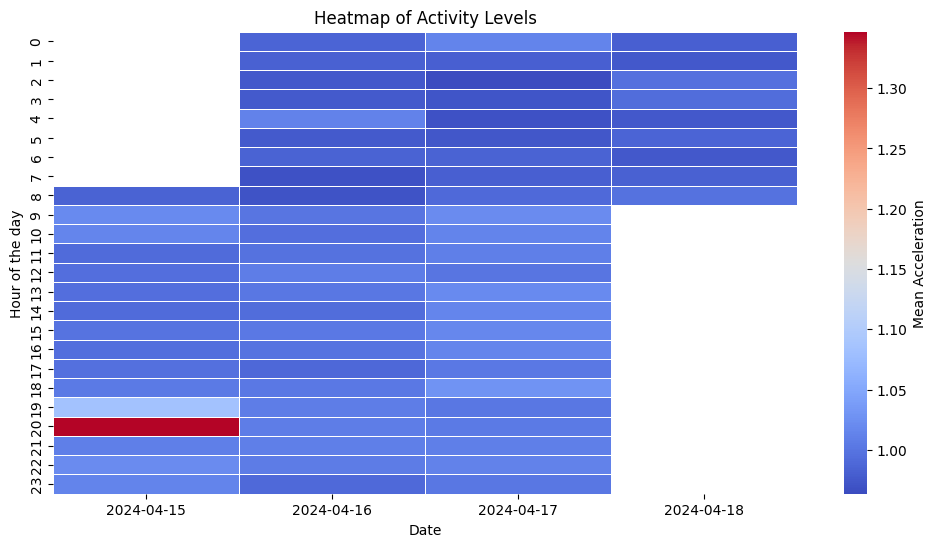

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

class InactivityDetector:
    def __init__(self, df, epoch_size=5, inactivity_threshold='dynamic'):
        """
        :param df: DataFrame contenant les colonnes ['date_heure', 'X', 'Y', 'Z']
        :param epoch_size: Durée d'une période d'analyse en secondes (ex: 5s)
        :param inactivity_threshold: Seuil d'inactivité ('dynamic' ou une valeur fixe)
        """
        self.df = df.copy()
        self.epoch_size = epoch_size
        self.inactivity_threshold = inactivity_threshold
        self.processed_data = None
        self._prepare_data()
    
    def _prepare_data(self):
        """Calcule l'accélération globale et prépare les données."""
        self.df['acceleration'] = np.sqrt(self.df['X']**2 + self.df['Y']**2 + self.df['Z']**2)
        self.df['timestamp'] = pd.to_datetime(self.df['date_heure'])
        self.df = self.df.sort_values('timestamp')
        self.df['epoch'] = self.df['timestamp'].dt.floor(f'{self.epoch_size}s')
        self.df['date'] = self.df['timestamp'].dt.date
    
    def detect_inactivity(self):
        """Détecte les périodes d'inactivité."""
        grouped = self.df.groupby(['epoch', 'date']).agg({'acceleration': 'mean'}).reset_index()
        
        # Déterminer un seuil d'inactivité dynamique
        if self.inactivity_threshold == 'dynamic':
            mean_acc = grouped['acceleration'].mean()
            std_acc = grouped['acceleration'].std()
            threshold = max(0.1, mean_acc - 0.5 * std_acc)  # Évite un seuil négatif ou trop bas
        else:
            threshold = self.inactivity_threshold
        
        grouped['inactive'] = grouped['acceleration'] < threshold
        
        # Ajout de segments d’inactivité pour les afficher correctement
        grouped['inactive_group'] = (grouped['inactive'] != grouped['inactive'].shift()).cumsum()

        self.processed_data = grouped
        return grouped
    
    def visualize_inactivity_per_day(self): 
        """Affiche un graphique interactif par jour pour voir les périodes d'inactivité."""
        if self.processed_data is None:
            self.detect_inactivity()
        
        unique_dates = self.processed_data['date'].unique()
        for day in unique_dates:
            daily_data = self.processed_data[self.processed_data['date'] == day]

            fig = go.Figure()

            # Courbe d'accélération
            fig.add_trace(go.Scatter(
                x=daily_data['epoch'], 
                y=daily_data['acceleration'],
                mode='lines',
                name='Acceleration',
                line=dict(color='blue')
            ))

            # Zones d'inactivité (remplissage par segments)
            for _, group in daily_data.groupby('inactive_group'):
                if group['inactive'].iloc[0]:  # Remplir uniquement les périodes inactives
                    fig.add_trace(go.Scatter(
                        x=group['epoch'],
                        y=group['acceleration'],
                        mode='lines',
                        fill='tozeroy',
                        fillcolor='rgba(255, 0, 0, 0.3)',
                        name='Inactive Periods',
                        line=dict(width=0)
                    ))

            fig.update_layout(
                title=f"Detection of Inactivity Periods - {day}",
                xaxis_title="Time",
                yaxis_title="Acceleration",
                hovermode="x",
                template="plotly_white"
            )

            fig.show()

    def heatmap_activity(self):
        """Génère une heatmap des niveaux d'activité heure par heure."""
        self.df['hour'] = self.df['timestamp'].dt.hour
        heatmap_data = self.df.pivot_table(index='hour', columns='date', values='acceleration', aggfunc='mean')
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Mean Acceleration'})
        plt.title('Heatmap of Activity Levels')
        plt.xlabel('Date')
        plt.ylabel('Hour of the day')
        plt.show()




# Créer et exécuter l'analyseur
detector = InactivityDetector(df_resampled, epoch_size=5, inactivity_threshold='dynamic')
detector.detect_inactivity()
detector.visualize_inactivity_per_day()  # Affiche un graphique par jour
detector.heatmap_activity()  # Affiche la heatmap de l'activité


Modif : 

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:96: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:104: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



🔹 Fixed Scale: Min=0.95, Max=1.53


/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:119: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:122: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





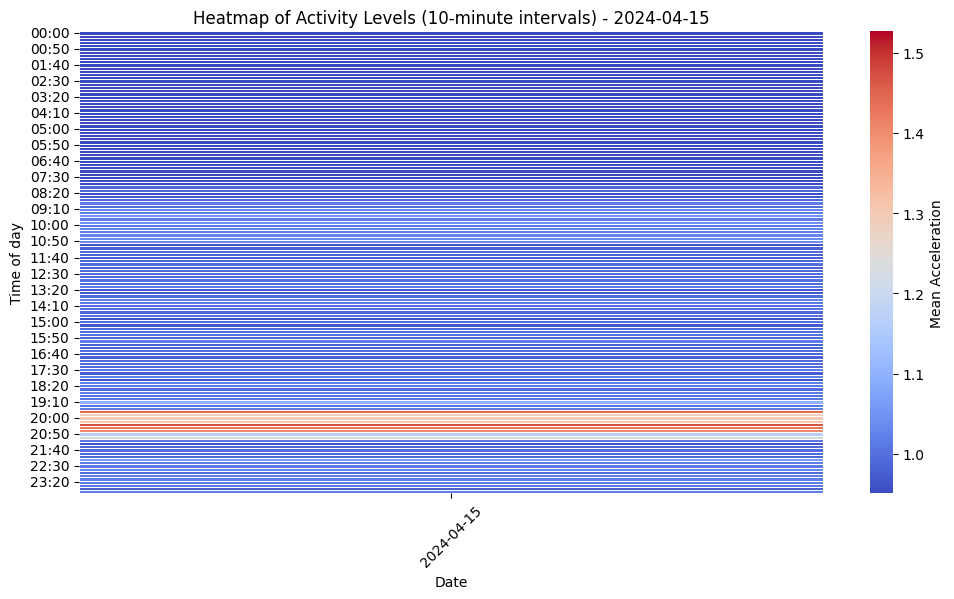

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:119: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:122: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





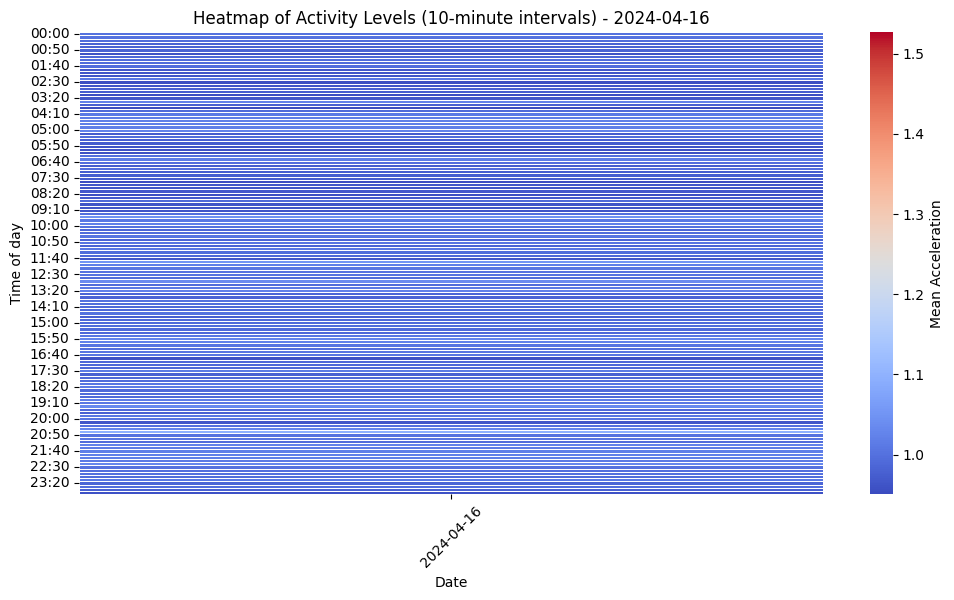

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:119: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:122: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





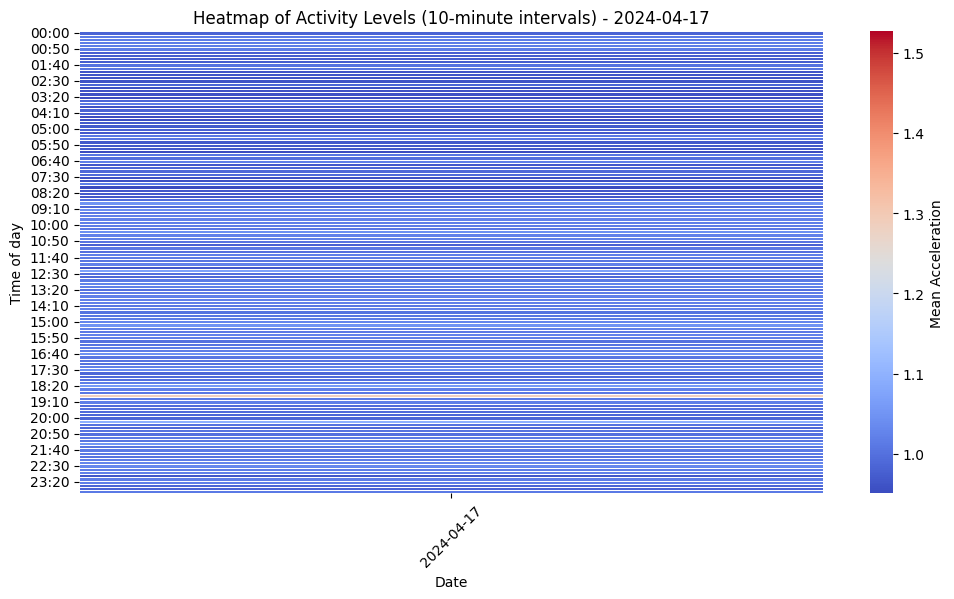

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:119: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_43367/1784552172.py:122: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





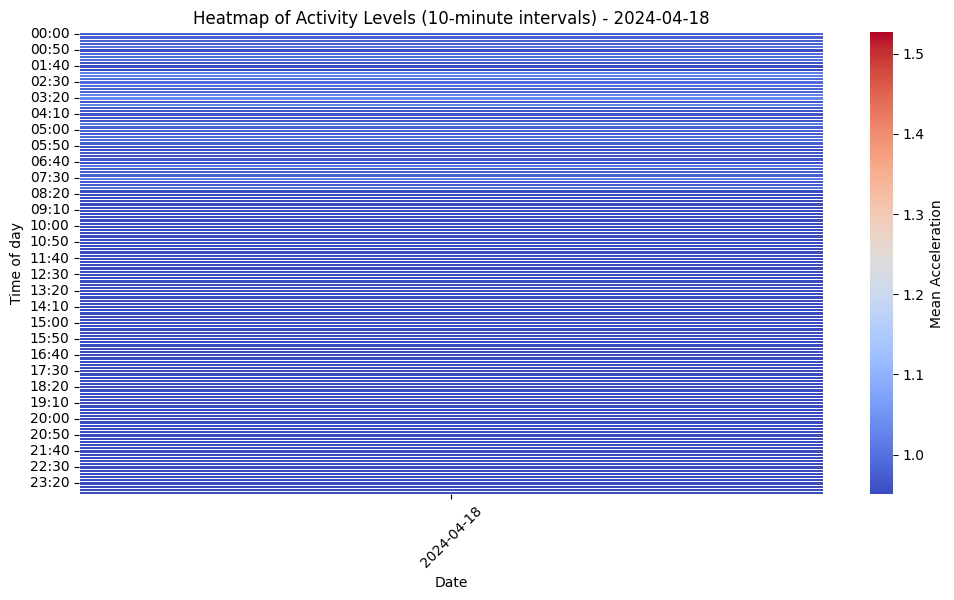

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

class InactivityDetector:
    def __init__(self, df, epoch_size=5, inactivity_threshold='dynamic'):
        """
        :param df: DataFrame containing the columns ['date_heure', 'X', 'Y', 'Z']
        :param epoch_size: Duration of an analysis period in seconds (e.g., 5s)
        :param inactivity_threshold: Inactivity threshold ('dynamic' or a fixed value)
        """
        self.df = df.copy()
        self.epoch_size = epoch_size
        self.inactivity_threshold = inactivity_threshold
        self.processed_data = None
        self._prepare_data()
    
    def _prepare_data(self):
        """Computes global acceleration and prepares the dataset."""
        self.df['acceleration'] = np.sqrt(self.df['X']**2 + self.df['Y']**2 + self.df['Z']**2)
        self.df['timestamp'] = pd.to_datetime(self.df['date_heure'])
        self.df = self.df.sort_values('timestamp')
        self.df['epoch'] = self.df['timestamp'].dt.floor(f'{self.epoch_size}s')
        self.df['date'] = self.df['timestamp'].dt.date
    
    def detect_inactivity(self):
        """Detects inactivity periods."""
        grouped = self.df.groupby(['epoch', 'date']).agg({'acceleration': 'mean'}).reset_index()
        
        # Determine a dynamic inactivity threshold
        if self.inactivity_threshold == 'dynamic':
            mean_acc = grouped['acceleration'].mean()
            std_acc = grouped['acceleration'].std()
            threshold = np.clip(mean_acc - 0.4 * std_acc, 0.2, 1.5)  # Dynamic adjustment with limits
        else:
            threshold = self.inactivity_threshold
        
        grouped['inactive'] = grouped['acceleration'] < threshold

        # Apply a median filter on inactivity to avoid false positives
        grouped['inactive'] = grouped['inactive'].rolling(window=3, min_periods=1, center=True).max()

        # Create groups for inactivity periods
        grouped['inactive_group'] = (grouped['inactive'] != grouped['inactive'].shift()).cumsum()

        self.processed_data = grouped
        return grouped
    
    def visualize_inactivity_per_day(self): 
        """Displays an interactive graph per day to visualize inactivity periods."""
        if self.processed_data is None:
            self.detect_inactivity()
        
        unique_dates = self.processed_data['date'].unique()
        for day in unique_dates:
            daily_data = self.processed_data[self.processed_data['date'] == day]

            fig = go.Figure()

            # Acceleration curve
            fig.add_trace(go.Scatter(
                x=daily_data['epoch'], 
                y=daily_data['acceleration'],
                mode='lines',
                name='Acceleration',
                line=dict(color='blue')
            ))

            # Inactivity zones (filled segments)
            for _, group in daily_data.groupby('inactive_group'):
                if group['inactive'].iloc[0]:  # Fill only inactive periods
                    fig.add_trace(go.Scatter(
                        x=group['epoch'],
                        y=group['acceleration'],
                        mode='lines',
                        fill='tozeroy',
                        fillcolor='rgba(255, 0, 0, 0.3)',
                        name='Inactive Periods',
                        line=dict(width=0)
                    ))

            fig.update_layout(
                title=f"Detection of Inactivity Periods - {day}",
                xaxis_title="Time",
                yaxis_title="Acceleration",
                hovermode="x",
                template="plotly_white"
            )

            fig.show()

    def compute_global_scale(self):
        """Calculates the min/max acceleration values to standardize the heatmap scale."""
        self.df['time_slot'] = self.df['timestamp'].dt.floor('10T')  # Round to 10-minute intervals
        global_stats = self.df.groupby('time_slot').agg({'acceleration': 'mean'})
        self.global_min = global_stats['acceleration'].min()
        self.global_max = global_stats['acceleration'].max()
        print(f"🔹 Fixed Scale: Min={self.global_min:.2f}, Max={self.global_max:.2f}")

    def heatmap_activity_per_day(self):
        """Displays a daily heatmap with activity levels every 10 minutes, using a fixed scale."""
        self.df['time_slot'] = self.df['timestamp'].dt.floor('10T')  # Round to 10-minute intervals
        self.df['date'] = self.df['timestamp'].dt.date
        self.df['hour_minute'] = self.df['timestamp'].dt.strftime('%H:%M')

        if self.global_min is None or self.global_max is None:
            self.compute_global_scale()  # 🔹 Fix min/max scale before plotting the heatmap

        unique_dates = self.df['date'].unique()
        for day in unique_dates:
            daily_data = self.df[self.df['date'] == day]

            # **Aggregate values to avoid duplicates**
            daily_data = daily_data.groupby(['hour_minute', 'date']).agg({'acceleration': 'mean'}).reset_index()

            # Generate a complete time range to prevent gaps
            all_times = pd.date_range(start="00:00", end="23:50", freq='10T').strftime('%H:%M')
            all_times_df = pd.DataFrame({'hour_minute': all_times, 'date': day})
            daily_data = pd.merge(all_times_df, daily_data, on=['hour_minute', 'date'], how='left')
            daily_data['acceleration'].fillna(self.global_min, inplace=True)  # 🔹 Avoid missing values

            # **Pivot after aggregation to avoid errors**
            heatmap_data = daily_data.pivot(index='hour_minute', columns='date', values='acceleration')

            plt.figure(figsize=(12, 6))
            sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5, 
                        cbar_kws={'label': 'Mean Acceleration'},
                        vmin=self.global_min, vmax=self.global_max)  # 🔹 FIXED SCALE

            plt.title(f'Heatmap of Activity Levels (10-minute intervals) - {day}')
            plt.xlabel('Date')
            plt.ylabel('Time of day')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)  # Clear display of time
            plt.show()


# **Execution**
detector = InactivityDetector(df_resampled, epoch_size=5, inactivity_threshold='dynamic')
detector.detect_inactivity()
detector.visualize_inactivity_per_day()  # Displays inactivity periods with corrections
detector.compute_global_scale()  # Fixes min/max scale
detector.heatmap_activity_per_day()  # Heatmap with a uniform scale


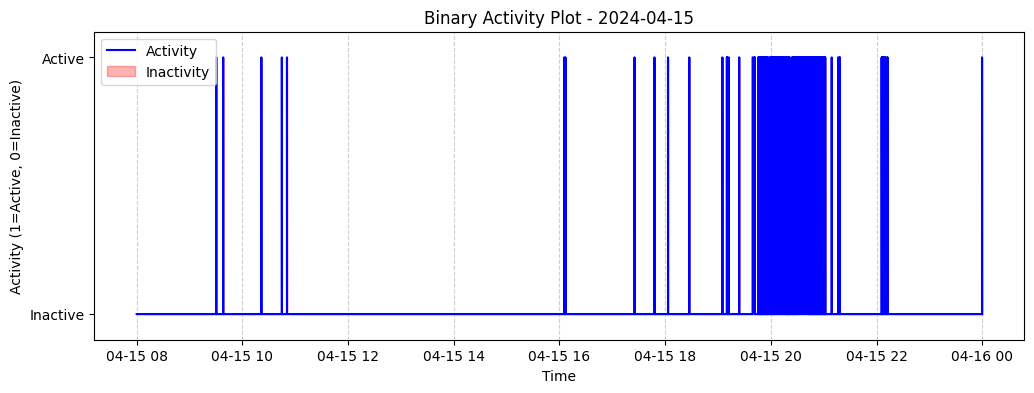

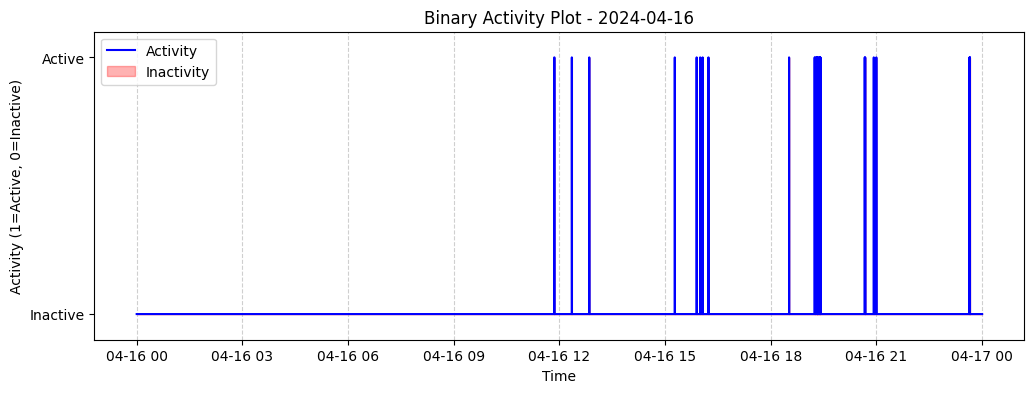

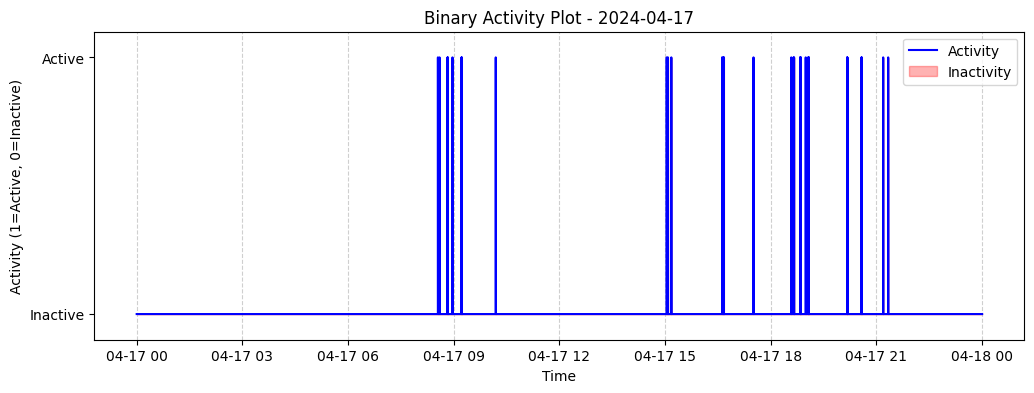

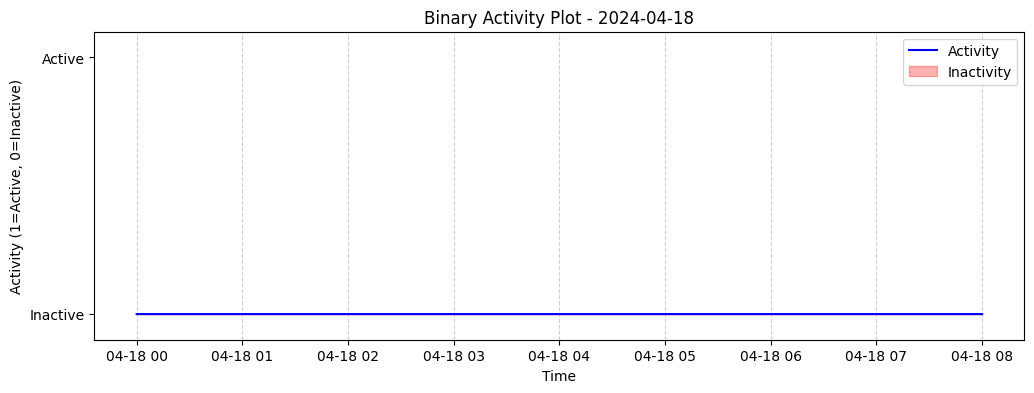

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class InactivityDetector:
    def __init__(self, df, epoch_size=5, activity_threshold=1.15):
        """
        :param df: DataFrame containing the columns ['date_heure', 'X', 'Y', 'Z']
        :param epoch_size: Duration of an analysis period in seconds (e.g., 5s)
        :param activity_threshold: Acceleration threshold above which a period is considered active
        """
        self.df = df.copy()
        self.epoch_size = epoch_size
        self.activity_threshold = activity_threshold
        self.processed_data = None
        self._prepare_data()
    
    def _prepare_data(self):
        """Computes global acceleration and prepares the dataset."""
        self.df['acceleration'] = np.sqrt(self.df['X']**2 + self.df['Y']**2 + self.df['Z']**2)
        self.df['timestamp'] = pd.to_datetime(self.df['date_heure'])
        self.df = self.df.sort_values('timestamp')
        self.df['epoch'] = self.df['timestamp'].dt.floor(f'{self.epoch_size}s')
        self.df['date'] = self.df['timestamp'].dt.date
    
    def detect_activity(self):
        """Detects activity and inactivity periods based on the threshold (1.15)."""
        grouped = self.df.groupby(['epoch', 'date']).agg({'acceleration': 'mean'}).reset_index()

        # **Binary classification: 1 = Active (acceleration > 1.15), 0 = Inactive**
        grouped['binary_activity'] = (grouped['acceleration'] > self.activity_threshold).astype(int)

        self.processed_data = grouped
        return grouped

    def plot_binary_activity_per_day(self):
        """Plots daily binary activity: 0 = Inactivity, 1 = Activity"""
        if self.processed_data is None:
            self.detect_activity()
        
        unique_dates = self.processed_data['date'].unique()
        for day in unique_dates:
            daily_data = self.processed_data[self.processed_data['date'] == day]

            plt.figure(figsize=(12, 4))
            plt.step(daily_data['epoch'], daily_data['binary_activity'], where='mid', color='blue', label='Activity')
            plt.fill_between(daily_data['epoch'], daily_data['binary_activity'], step="mid", color='red', alpha=0.3, label='Inactivity')

            plt.title(f'Binary Activity Plot - {day}')
            plt.xlabel('Time')
            plt.ylabel('Activity (1=Active, 0=Inactive)')
            plt.ylim(-0.1, 1.1)  # Keep the y-axis binary (0-1)
            plt.yticks([0, 1], labels=['Inactive', 'Active'])
            plt.grid(axis='x', linestyle='--', alpha=0.6)
            plt.legend()
            plt.show()


# **Execution**
detector = InactivityDetector(df_resampled, epoch_size=5, activity_threshold=1.15)
detector.detect_activity()
detector.plot_binary_activity_per_day()  


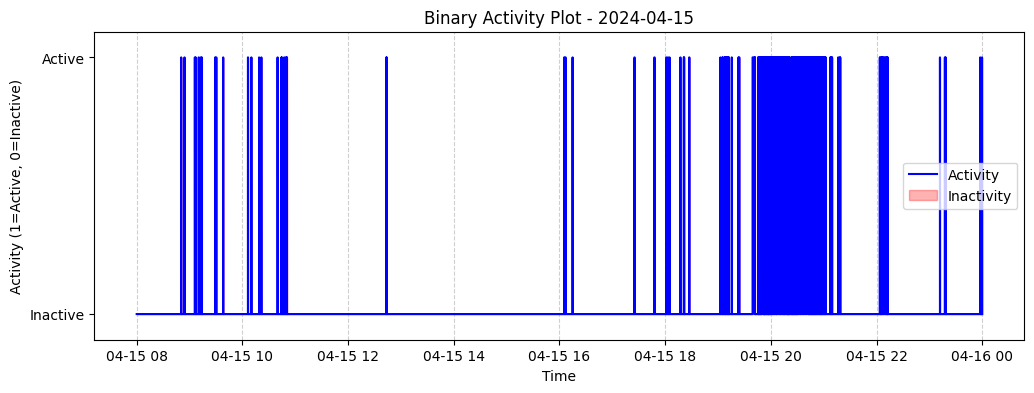

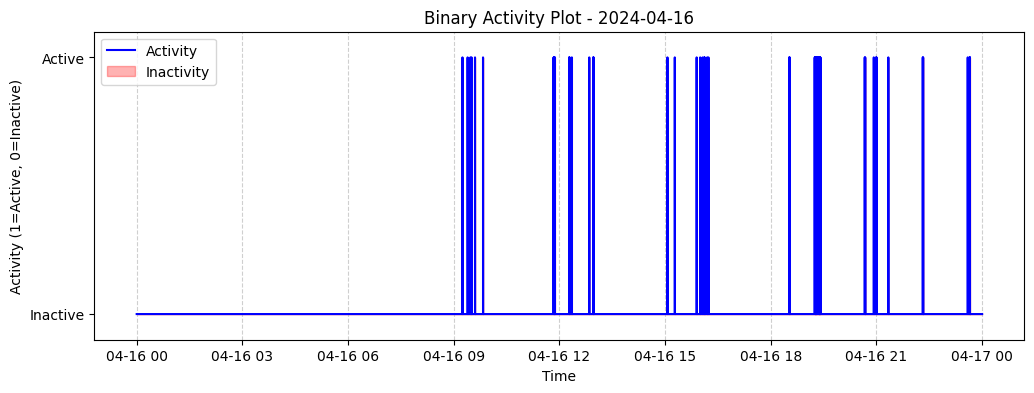

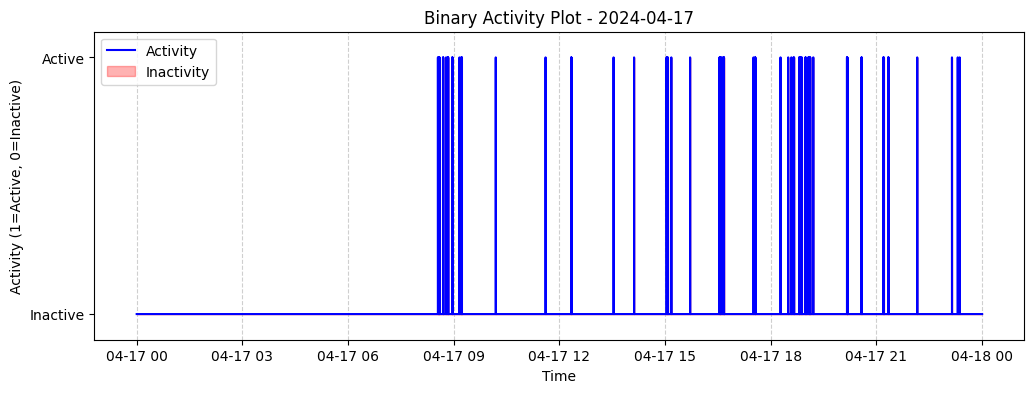

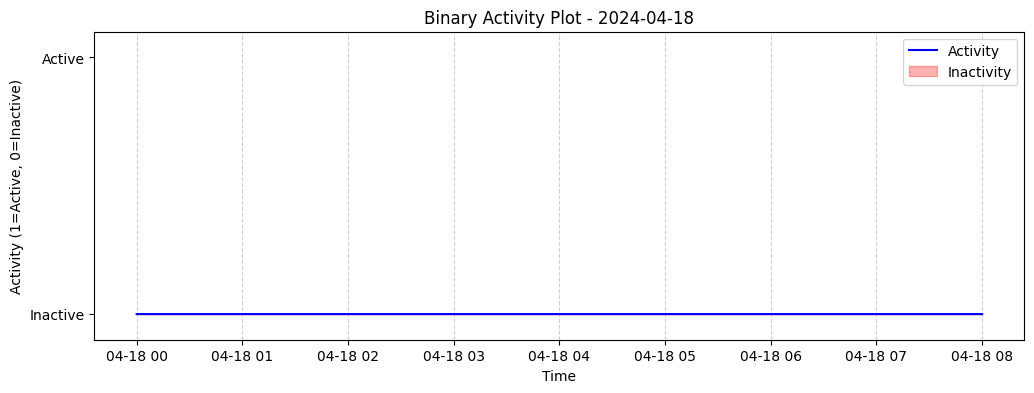

In [32]:
# **Execution**
detector = InactivityDetector(df_resampled, epoch_size=5, activity_threshold=1.10)
detector.detect_activity()
detector.plot_binary_activity_per_day()  


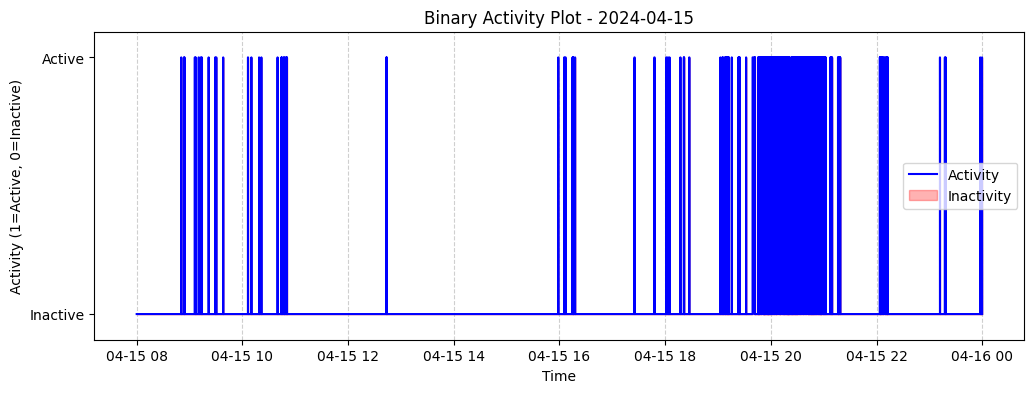

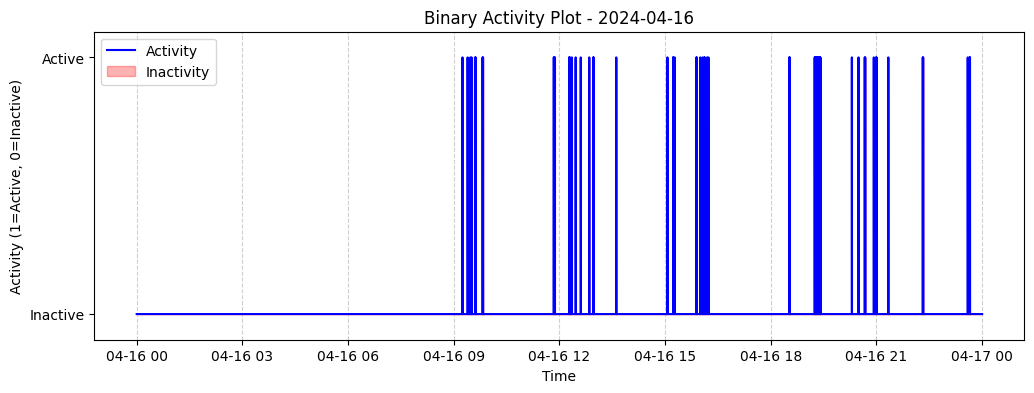

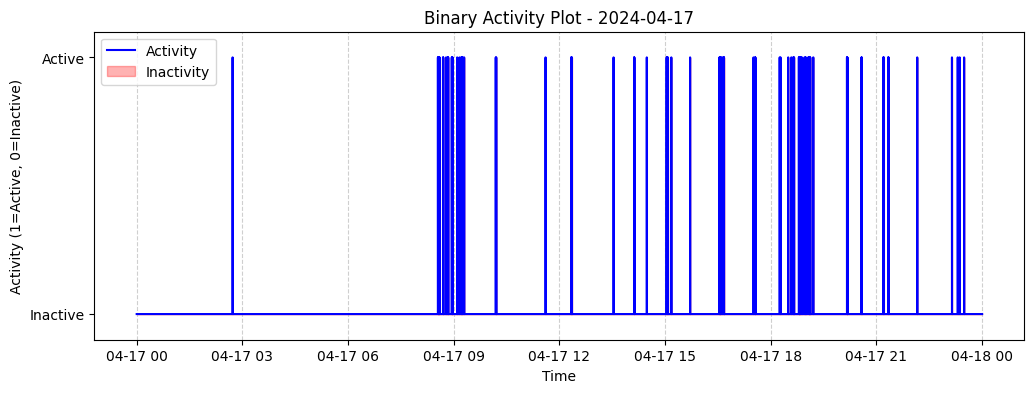

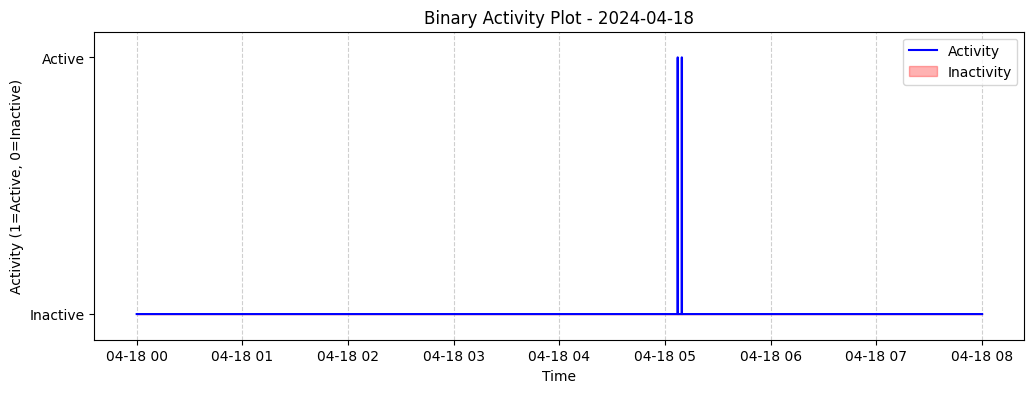

In [31]:
# **Execution**
detector = InactivityDetector(df_resampled, epoch_size=5, activity_threshold=1.09)
detector.detect_activity()
detector.plot_binary_activity_per_day() 
